In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

ancienne data
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
enregistrement_Test_2017-09-20_140343.asc
enregistrement_Test_2017-09-20_140343.edf
enregistrement_Test_2017-09-20_140343.pkl
pari_chloe_2017-09-12_154827.pkl
pari_LB_2017-09-19_152205 (copie).pkl
pari_LB_2017-09-19_152205_new.pkl
pari_LB_2017-09-19_152205.pkl
Untitled.ipynb


In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def anticipation (x, tau=0.013, xT=0.1, t_T=1, start_anti=500., v_anti=0.1, latence=1000., bino=0) :

#    tau = 0.013 # constante oeuil
#    xT = 1 # position deg de la cible
#    t_T = 0.1 # tps termine mvt - s
#    start_anti = debut de l'anticipation
#    v_anti =  vitesse de l'anticipation
#    latence = début de la poursuite
#    start = np.where(x==0)[0][0]
    
    if bino == 0:
        xT =xT*-1
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!
    start = latence/1000
    start_anti=start_anti/1000
    
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N
    x_max = Umax*tau*(1-np.exp(-1/tau*time[rhoT]))

    vitesse = []

    if start_anti >= start :
        for t in range(len(time)):
            if bino==0 :
                if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                    vitesse.append(0)
                else :
                    vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
            else :
                if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                    vitesse.append(0)
                else :
                    vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
    
    else :
        for t in range(len(time)):
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if bino==0 :
                    if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                        vitesse.append(((time[t]-start_anti)*v_anti))
                        x = (time[t]-start_anti)*v_anti
                    else :
                        vitesse.append((Umax*tau*(1-np.exp(-1/tau*(time[t]-start)))+x))
                else :
                    if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                        vitesse.append(((time[t]-start_anti)*v_anti))
                        x = (time[t]-start_anti)*v_anti
                    else :
                        vitesse.append((Umax*tau*(1-np.exp(-1/tau*(time[t]-start)))+x))
    return vitesse

[[Model]]
    Model(anticipation)
[[Fit Statistics]]
    # function evals   = 200
    # data points      = 1811
    # variables        = 6
    chi-square         = 97.129
    reduced chi-square = 0.054
    Akaike info crit   = -5286.247
    Bayesian info crit = -5253.237
[[Variables]]
    tau:          0.01300000 +/- 0        (0.00%) (init= 0.013)
    xT:           0.06175790 +/- 0        (0.00%) (init= 0.05)
    t_T:          0.14204496 +/- 0        (0.00%) (init= 0.1)
    latence:      1195.43814 +/- 0        (0.00%) (init= 1070)
    start_anti:   669.000000 +/- 0        (0.00%) (init= 669)
    v_anti:       0.01421946 +/- 0        (0.00%) (init= 0)
    bino:         0 (fixed)

669.00000085 0.0142194607752 1195.43814574 0.013 0.0617579019854 0.142044962508


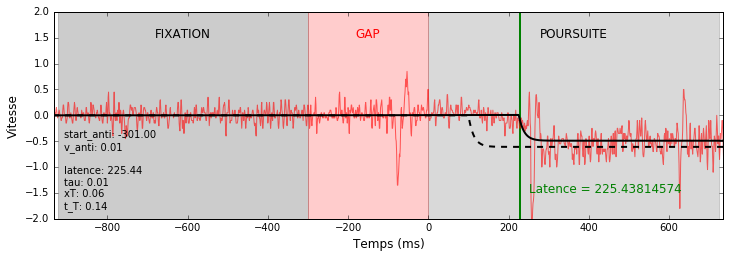

In [11]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 2
trial = 170


trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x)

# SUPPRESSION DES SACCADES
new_gradient_x=[]
new_time=[]
t=0
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_gradient_x.append(gradient_x[x_data])
        new_time.append(t)
        t = t+1
    saccade = None

StimulusOn_0 = StimulusOn
StimulusOf_0 = StimulusOf
TargetOn_0 = TargetOn
TargetOff_0 = TargetOff

for s in range(len(saccades)) :
    if StimulusOn_0 > (saccades[s][1]) :
        StimulusOn = StimulusOn - (saccades[s][2]+5)
    if StimulusOf_0 > (saccades[s][1]) :
        StimulusOf = StimulusOf - (saccades[s][2]+5)
    if TargetOn_0 > (saccades[s][1]) :
        TargetOn = TargetOn - (saccades[s][2]+5)
    if TargetOff_0 > (saccades[s][1]) :
        TargetOff = TargetOff - (saccades[s][2]+5)

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start
        
# FIT
model = Model(anticipation)
bino=p[trial, block, 0]
params = Parameters()
params.add('tau', value=0.013, min=0.013, max=0.02)#, vary=False)
params.add('xT', value=0.05, min=0.04, max=1)# , vary=False)
params.add('t_T', value= 0.1, min=0.05, max=0.2)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_x))

params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0, max=len(new_gradient_x))
params.add('v_anti', value=0., min=-0.89, max=0.89)

params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)

debut  = TargetOn - trackertime_0 # TargetOn - temps_0


axs.axis([StimulusOn_s-10, TargetOff_s+10, -2, 2])

axs.plot(np.asarray(new_time)-debut, new_gradient_x, color='r', alpha=0.6)
axs.plot(np.asarray(new_time)-debut, result.init_fit, 'k--', linewidth=2)
axs.plot(np.asarray(new_time)-debut, result.best_fit, color='k', linewidth=2)


axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

start_anti = result.values['start_anti']
v_anti = result.values['v_anti']
latence = result.values['latence']
tau = result.values['tau']
xT = result.values['xT']
t_T = result.values['t_T']

axs.bar(latence-debut, 4, bottom=-2, color='g', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 1.5, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 1.5, "GAP", color='r', fontsize=12, horizontalalignment='center')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 1.5, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
axs.text(latence-debut+25, -1.5, "Latence = %s"%(latence-debut), color='g', fontsize=12)#,  weight='bold')
#axs.text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=10)
axs.text(StimulusOn_s+15, -1.8, "start_anti: %4.2f \nv_anti: %0.2f \n\nlatence: %4.2f \ntau: %0.2f \nxT: %0.2f \nt_T: %0.2f"%(start_anti-debut, v_anti, latence-debut, tau, xT, t_T), color='k', fontsize=10)

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

print(result.fit_report())
print(start_anti, v_anti, latence, tau, xT, t_T)


In [ ]:
for block in range(N_blocks) :
    fig_width= 12
    fig, axs = plt.subplots(N_trials, 1, figsize=(fig_width, (fig_width*(N_trials/2))/1.6180))
    
    for trial in range(N_trials) :
        
        print(block, trial)
        
        trial_data = trial + N_trials*block
        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']

        trackertime_0 = data[trial_data]['trackertime'][0]

        gradient_x = np.gradient(data_x)
        
        # SUPPRESSION DES SACCADES
        new_gradient_x=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_x.append(gradient_x[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        StimulusOn_0 = StimulusOn
        StimulusOf_0 = StimulusOf
        TargetOn_0 = TargetOn
        TargetOff_0 = TargetOff

        for s in range(len(saccades)) :
            if StimulusOn_0 > (saccades[s][1]) :
                StimulusOn = StimulusOn - (saccades[s][2]+5)
            if StimulusOf_0 > (saccades[s][1]) :
                StimulusOf = StimulusOf - (saccades[s][2]+5)
            if TargetOn_0 > (saccades[s][1]) :
                TargetOn = TargetOn - (saccades[s][2]+5)
            if TargetOff_0 > (saccades[s][1]) :
                TargetOff = TargetOff - (saccades[s][2]+5)

        start = TargetOn

        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start
        
        
        # FIT
        model = Model(anticipation)

        bino=p[trial, block, 0]
        params = Parameters()
        params.add('tau', value=0.013, min=0.013, max=0.02)#, vary=False)
        params.add('xT', value=0.05, min=0.04, max=1)# , vary=False)
        params.add('t_T', value= 0.1, min=0.05, max=0.2)#, vary=False)
        params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_x))

        params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0, max=len(new_gradient_x))
        params.add('v_anti', value=0., min=-0.89, max=0.89)

        params.add('bino', value=bino, min=0, max=1, vary=False)

        result = model.fit(new_gradient_x, params, x=new_time)

        debut  = TargetOn - trackertime_0 # TargetOn - temps_0
        
        axs[trial].cla() # pour remettre ax figure a zero
        axs[trial].axis([StimulusOn_s-10, TargetOff_s+10, -2, 2])
        axs[trial].plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
        axs[trial].plot(np.asarray(new_time)-debut, result.init_fit, 'k--')
        axs[trial].plot(np.asarray(new_time)-debut, result.best_fit, color='k')

        
        axs[trial].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
        axs[trial].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
        axs[trial].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

        
        start_anti = result.values['start_anti']
        v_anti = result.values['v_anti']
        latence = result.values['latence']
        tau = result.values['tau']
        xT = result.values['xT']
        t_T = result.values['t_T']
        
        axs[trial].bar(latence-debut, 4, bottom=-2, color='g', width=6, linewidth=0)
        
        axs[trial].text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 1.5, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 1.5, "GAP", color='r', fontsize=12, horizontalalignment='center')
        axs[trial].text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 1.5, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(latence-debut+25, -1.5, "Latence = %s"%(latence-debut), color='g', fontsize=12)#,  weight='bold')
        #axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)
        axs[trial].text(StimulusOn_s+15, -1.8, "start_anti: %4.2f \nv_anti: %0.2f \n\nlatence: %4.2f \ntau: %0.2f \nxT: %0.2f \nt_T: %0.2f"%(start_anti-debut, v_anti, latence-debut, tau, xT, t_T), color='k', fontsize=10)

        
        axs[trial].set_xlabel('Time (ms)', fontsize=9)
        axs[trial].set_ylabel(trial+1, fontsize=9)

    plt.tight_layout() # pour supprimer les marge trop grande
    plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures

    plt.savefig('figures/Fit_anticipation_%s_%s_block-%s.pdf'%(observer, timeStr, block+1))
plt.close()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184
